## Will our customers rent a film this month?

In order to know if the customers form our storse will rent a film nex noth we have to look at their previous activity and other details. Therefore, the variables incluided in our dataframe will be:

    Customer ID
    City
    Most rented film category
    Total films rented
    Total money spent
    How many films rented last month (MAY/2005)
    If the customer rented a movie this month (JUNE/2005)
    
First of all, let's rigth down our query and build our dataframe.

In [56]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np


from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import getpass  # to get the password without showing the input
password = getpass.getpass()

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

········


In [31]:
query='''SELECT customer_table.customer_id, city, category, number_of_films_rented, total_money_spent, table_query4.films_rented_may_2005, table_query5.question
FROM query1 as table_query1 
LEFT JOIN query2 as table_query2 on table_query1.customer_id = table_query2.customer_id
LEFT JOIN query3 as table_query3 on table_query1.customer_id = table_query3.customer_id
LEFT JOIN query4 as table_query4 on table_query1.customer_id = table_query4.customer_id
LEFT JOIN query5 as table_query5 on table_query1.customer_id = table_query5.customer_id
LEFT JOIN sakila.customer as customer_table on table_query1.customer_id = customer_table.customer_id 
LEFT JOIN sakila.address as address_table on customer_table.address_id = address_table.address_id
LEFT JOIN sakila.city as city_table on address_table.city_id = city_table.city_id
;'''

data=pd.read_sql_query(query,engine)
data

,customer_id,city,category,number_of_films_rented,total_money_spent,films_rented_may_2005,question
0,1,Sasebo,Classics,1024,3797.76,64.0,YES
1,2,San Bernardino,Sports,729,3475.71,27.0,YES
2,3,Athenai,Action,676,3529.24,52.0,YES
3,4,Myingyan,Horror,484,1799.16,NaN,YES
4,5,Nantou,Classics,1444,5495.56,114.0,YES
...,...,...,...,...,...,...,...
594,595,Jinzhou,Documentary,900,3531.00,30.0,YES
595,596,Patras,Sports,784,2708.16,168.0,YES
596,597,Sullana,Foreign,625,2493.75,50.0,YES
597,598,Lausanne,Comedy,484,1843.16,NaN,YES


In [32]:
data=data.set_index('customer_id')
data

,city,category,number_of_films_rented,total_money_spent,films_rented_may_2005,question
customer_id,,,,,,
1,Sasebo,Classics,1024,3797.76,64.0,YES
2,San Bernardino,Sports,729,3475.71,27.0,YES
3,Athenai,Action,676,3529.24,52.0,YES
4,Myingyan,Horror,484,1799.16,NaN,YES
5,Nantou,Classics,1444,5495.56,114.0,YES
...,...,...,...,...,...,...
595,Jinzhou,Documentary,900,3531.00,30.0,YES
596,Patras,Sports,784,2708.16,168.0,YES
597,Sullana,Foreign,625,2493.75,50.0,YES


## Anybody said NANs?

Once we have our main dataframe. Lets explore its features. Since we have done a left join on our tables. We should be aware of the null values:

    ·Our data frame contain 79 null values in the variable "films_rented_may_2005". Which we can confirm, after reviewing carefully our query, than they must be replaced by zeros.
    
    ·We have 9 null values in our variable "question". Those nine valies correspond to the people who did not rented a film. Therefore, they must be replaced by NOs
    
Let's replace them!

In [33]:
data.isna().sum()

city                       0
category                   0
number_of_films_rented     0
total_money_spent          0
films_rented_may_2005     79
question                   9
dtype: int64

In [34]:
data["question"].fillna("NO", inplace=True)

In [35]:
data["films_rented_may_2005"].fillna('0', inplace=True)

In [36]:
data.isna().sum()

city                      0
category                  0
number_of_films_rented    0
total_money_spent         0
films_rented_may_2005     0
question                  0
dtype: int64

In [37]:
data

,city,category,number_of_films_rented,total_money_spent,films_rented_may_2005,question
customer_id,,,,,,
1,Sasebo,Classics,1024,3797.76,64,YES
2,San Bernardino,Sports,729,3475.71,27,YES
3,Athenai,Action,676,3529.24,52,YES
4,Myingyan,Horror,484,1799.16,0,YES
5,Nantou,Classics,1444,5495.56,114,YES
...,...,...,...,...,...,...
595,Jinzhou,Documentary,900,3531.00,30,YES
596,Patras,Sports,784,2708.16,168,YES
597,Sullana,Foreign,625,2493.75,50,YES


## Let's explore our date deeply

First, we check if our variables are expressed the way we want for our model. If not, we apply the corresponding transformation. Which in this case, would be to convert the films_rented_may_2005 float type variable into an integer type variable. Because, nobody is going
to rent 65,5 films.

In [38]:
data.dtypes

city                       object
category                   object
number_of_films_rented      int64
total_money_spent         float64
films_rented_may_2005      object
question                   object
dtype: object

In [39]:
data['films_rented_may_2005'] = data['films_rented_may_2005'].apply(lambda x: int((float(x))))
data

,city,category,number_of_films_rented,total_money_spent,films_rented_may_2005,question
customer_id,,,,,,
1,Sasebo,Classics,1024,3797.76,64,YES
2,San Bernardino,Sports,729,3475.71,27,YES
3,Athenai,Action,676,3529.24,52,YES
4,Myingyan,Horror,484,1799.16,0,YES
5,Nantou,Classics,1444,5495.56,114,YES
...,...,...,...,...,...,...
595,Jinzhou,Documentary,900,3531.00,30,YES
596,Patras,Sports,784,2708.16,168,YES
597,Sullana,Foreign,625,2493.75,50,YES


## Our numerical data

We can see that we may have outliers but that they wont be a lot, since our maximum values and the 75% quartile are not so far from each other.

In [40]:
data.describe()

,number_of_films_rented,total_money_spent,films_rented_may_2005
count,599.000000,599.000000,599.000000
mean,743.751252,3127.400551,53.287145
std,283.263760,1274.903607,43.397876
min,144.000000,634.560000,0.000000
25%,529.000000,2232.700000,25.000000
50%,676.000000,2943.750000,46.000000
75%,900.000000,3800.580000,70.000000
max,2116.000000,9969.750000,320.000000


Let's plot it to check it

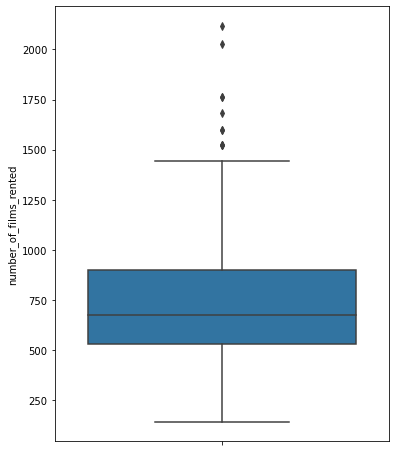

In [41]:
plt.figure(figsize=(6,8))
sns.boxplot(y="number_of_films_rented", data=data)
plt.show()

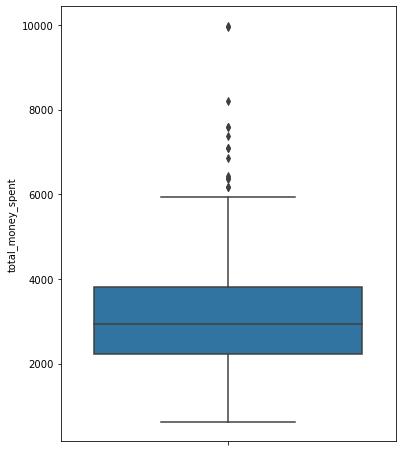

In [42]:
plt.figure(figsize=(6,8))
sns.boxplot(y="total_money_spent", data=data)
plt.show()

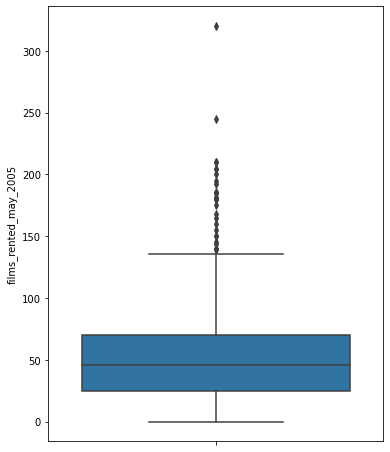

In [43]:
plt.figure(figsize=(6,8))
sns.boxplot(y="films_rented_may_2005", data=data)
plt.show()

### Are their distributiones pretty?

We see that the variable with the highest number of outliers is 'films_rented_may_2005'. But since they are not a huge amount, they might not 'disturb' us. This one is also the less normaly distributed. 

Isn't it clear with the boxplot?

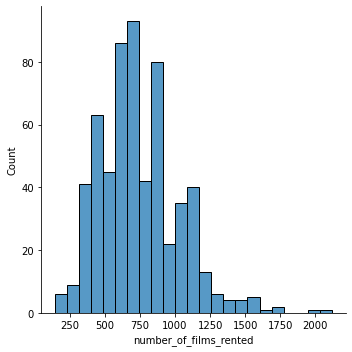

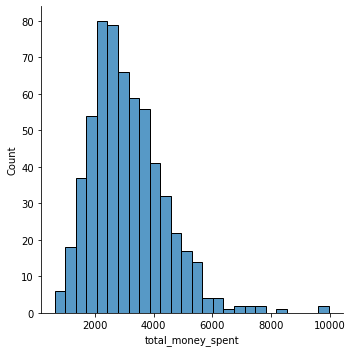

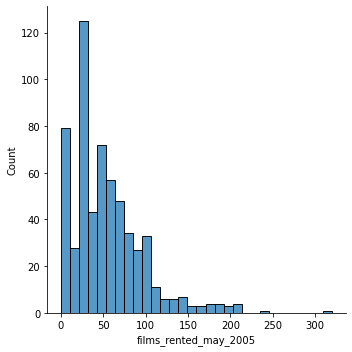

In [44]:
for col in data.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show()

Bit skewed to the right all of them. Which one the most? 'films_rented_may_2005' as we already saw before. It is not only skewed but also have few futher outliers and less normal distribution than the others.

#### Would this affect our model? 

We will see

#### What about their relations to each other?

We clearly see that 'total_money_spent' has a high positive correlation witht the 'number_of_films_rented'. But our logic said that before.

However, the correlation between 'films_rented_may_2005' and the two others is kindda exponential? totale uncorrelated? What we should take into account here is that, both variables are a TOTAL from a WHOLE period, meanwhile the TOTAL from films_rented_may_2005 is just from A MONTH period.

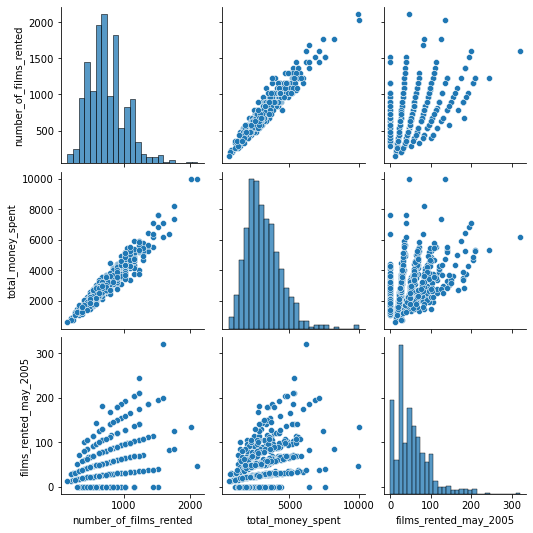

In [48]:
sns.pairplot(data)

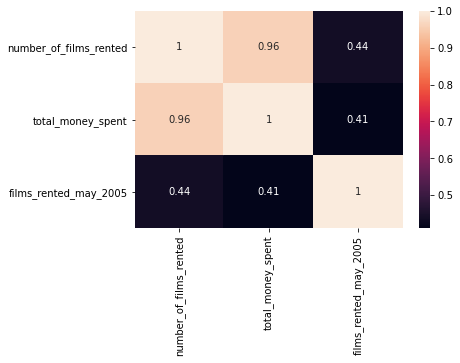

In [50]:
corr_data = data.select_dtypes([np.number])
correlations_matrix = corr_data.corr()  # method='spearman'
correlations_matrix
sns.heatmap(correlations_matrix, annot=True) 
plt.show()

## Our categorical data

Let's see now how are our categorical varibales and their relationship with the numerical ones.

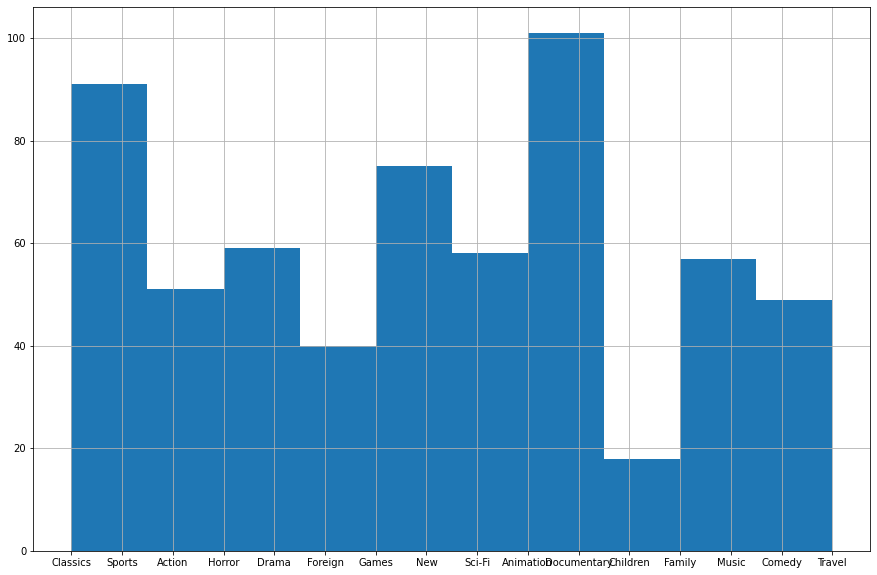

In [45]:
plt.figure(figsize=(15,10))
data['category'].hist()
plt.show()

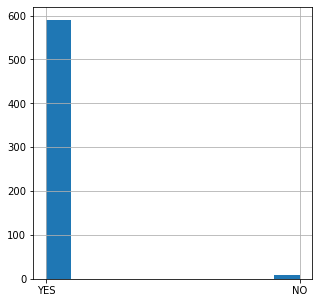

In [47]:
plt.figure(figsize=(5,5))
data['question'].hist()
plt.show()

#### we already know this may cause some problems in our model...

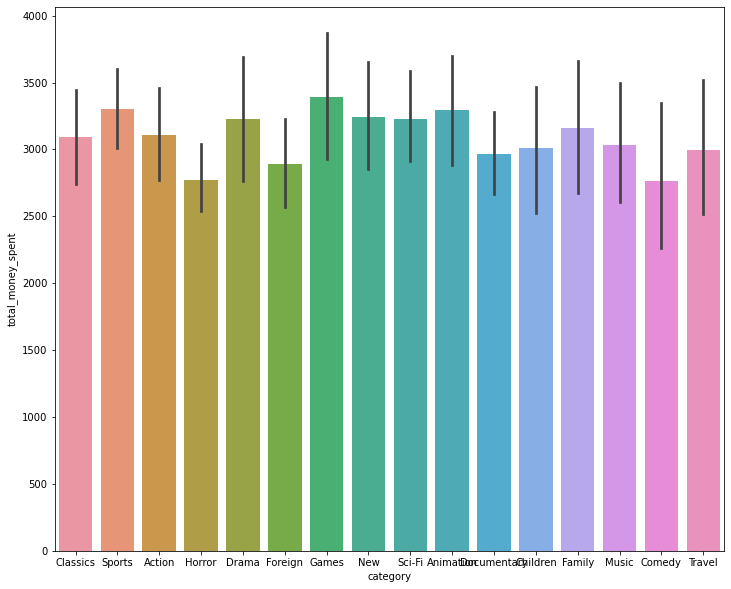

In [51]:
plt.figure(figsize=(12,10))
sns.barplot(x="category", y="total_money_spent", data=data)
plt.show()

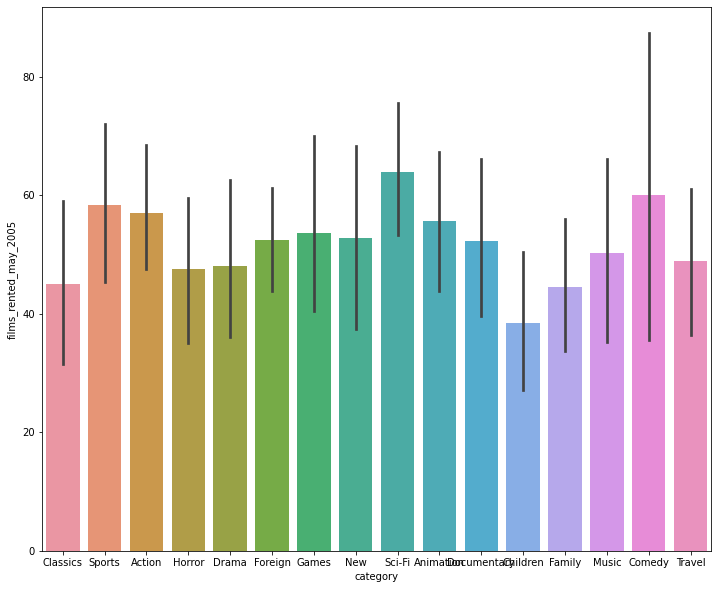

In [53]:
plt.figure(figsize=(12,10))
sns.barplot(x="category", y="films_rented_may_2005", data=data)
plt.show()

## Our model

Let's focus. We want to know wether our customers will be renting a film this month or not. Therefore, our target variable is going to be 'question'. 

In order to properly build and train our model we first have to dummify our categorical variables. 

AND take care of the imbalance we saw before in our target.

In [57]:
data["question"].value_counts()

YES    590
NO       9
Name: question, dtype: int64

In [58]:
data=pd.get_dummies(data,columns=['category'])

In [59]:
from imblearn.over_sampling import SMOTE

In [60]:
# SMOTE
# Uses knn to create rows with similar features from the minority classes.

smote = SMOTE()

X = data.drop(columns=['question','city'])
y = data['question']

X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

YES    590
NO     590
Name: question, dtype: int64

#### sovled?

Let's say, fixed for our purpose

We have done an upsampling to our original data. Since the sample is small but the imbalance is huge, the upsamplig will work better than de down sampling.

However, it has consequences that we will talk about after

In [61]:
X_sm

,number_of_films_rented,total_money_spent,films_rented_may_2005,category_Action,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
0,1024,3797.760000,64,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,729,3475.710000,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,676,3529.240000,52,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,484,1799.160000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1444,5495.560000,114,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,559,2234.271098,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1176,551,2617.724536,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1177,443,1585.240289,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1178,563,2273.219990,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Let's train our model

In [80]:
X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

In [81]:
classification = LogisticRegression(random_state=42, max_iter=20000)
classification.fit(X_sm_train, y_sm_train)

LogisticRegression(max_iter=20000, random_state=42)

In [82]:
classification.score(X_sm_test, y_sm_test)

0.9364406779661016

#### Kindda cool right?

Looks like our model is able to predict with a 93.64% accuracy if a customer will rent a film this month

Let's re-think how good is this

In [83]:
predictions = classification.predict(X_sm_test)
confusion_matrix(y_sm_test, predictions)

array([[117,   3],
       [ 12, 104]], dtype=int64)

In [84]:
pd.Series(predictions).value_counts()

NO     129
YES    107
dtype: int64

In [85]:
y_sm_test.value_counts()

NO     120
YES    116
Name: question, dtype: int64

<AxesSubplot:>

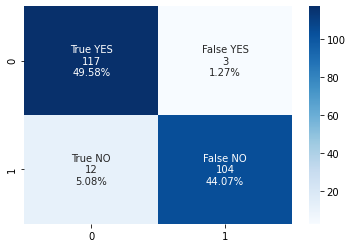

In [86]:
cf_matrix = confusion_matrix(y_sm_test, predictions)
group_names = ['True YES', 'False YES', 'True NO', 'False NO']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [87]:
print(metrics.classification_report(y_sm_test, predictions))

              precision    recall  f1-score   support

          NO       0.91      0.97      0.94       120
         YES       0.97      0.90      0.93       116

    accuracy                           0.94       236
   macro avg       0.94      0.94      0.94       236
weighted avg       0.94      0.94      0.94       236



In [89]:
'''from sklearn import metrics

def plot_multiclass_roc(clf, X_sm_test, y_sm_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_sm_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_sm_test_dummies = pd.get_dummies(y_sm_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_sm_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(classification, X_sm_test, y_sm_test, n_classes=4, figsize=(16, 10))'''

'from sklearn import metrics\n\ndef plot_multiclass_roc(clf, X_sm_test, y_sm_test, n_classes, figsize=(17, 6)):\n    y_score = clf.decision_function(X_sm_test)\n\n    # structures\n    fpr = dict()\n    tpr = dict()\n    roc_auc = dict()\n\n    # calculate dummies once\n    y_sm_test_dummies = pd.get_dummies(y_sm_test, drop_first=False).values\n    for i in range(n_classes):\n        fpr[i], tpr[i], _ = metrics.roc_curve(y_sm_test_dummies[:, i], y_score[:, i])\n        roc_auc[i] = metrics.auc(fpr[i], tpr[i])\n\n    # roc for each class\n    fig, ax = plt.subplots(figsize=figsize)\n    ax.plot([0, 1], [0, 1], \'k--\')\n    ax.set_xlim([0.0, 1.0])\n    ax.set_ylim([0.0, 1.05])\n    ax.set_xlabel(\'False Positive Rate\')\n    ax.set_ylabel(\'True Positive Rate\')\n    ax.set_title(\'Receiver operating characteristic example\')\n    for i in range(n_classes):\n        ax.plot(fpr[i], tpr[i], label=\'ROC curve (area = %0.2f) for label %i\' % (roc_auc[i], i))\n    ax.legend(loc="best")\n   

### Conclusions

The predictions we are getting with our model are quite accurate. May be, too accurate?

The objective of our study is to know whether a customer will rent a film or not. Because we want to lunch a 'Loyalty Programm' to our most loyal customers.

In this sense, do I have all the data I need? May be, we will need to see the tendecy of our customers and not only a one-month value (films_rented_may_2005).

Moreover, (and most important from my point of view) we have a huge imbalance in our target variable. So, our model is going to be 'biased'. Eventhough, we correct our imbalance, we have to take into account that we are overfitting our model. We are, indeed, doubling our data just to 'balance' our imbalance.

This is what our confusion matrix somehow is telling us. The proportions of TRUE NOs is way lower than the proportion of FALSE NOs. However, our model seems to be very accurate in predicting the YES, ofc.

#### So, what if we want to know which categroy is going to be rented? How good is our model then? Let's see -->